<img align="center" style="max-width: 900px; height: auto" src="https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/assets/banner.png?raw=1">

###  Coding Challenge - Getting Started

<img align="right" style="max-width: 200px; height: auto" src="https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/cc_1/hsg_logo.png?raw=1">
<img align="center" style="max-width: 300px; height: auto" src="https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/cc_1/sentinel2.jpg?raw=1">

8,860,1.00 MCS Machine Learning, Spring Term 2025, University of St.Gallen (HSG)

The lab environment of the **8,860,1.00 Machine Learning** course is powered by Jupyter Notebooks (https://jupyter.org), which allows one to perform a great deal of data analysis and statistical validation. In this first lab, we want to touch on the basic concepts and techniques of such notebooks. Furthermore, its capabilities will be demonstrated based on a few simple and introductory examples.

### Objectives:

With the help of this notebook you should be able to:
    
> 1. Understand the basic funcitonality of the rasterio framework
> 2. Apply rasterio to load GTiff data
> 3. Visualize multi-band satellite imagery
> 4. Perform basic band arithmetic to compute the normalized difference vegetation index (NDVI)
> 5. Load and display samples from the challenge testset

## 2. Setup of the Jupyter Notebook Environment

Similar to the previous labs, we need to import a couple of Python libraries that allow for data analysis and data visualization. We will use `os` and `glob` to collect the filepaths for the data samples, `numpy` for array operations, `matplotlib` to display images, and `rasterio` to handle raster data. You can find the documentation of the `rasterio` library with an overview of its functionality [here](https://rasterio.readthedocs.io).

In [1]:
!pip install rasterio matplot
import os
import glob
import numpy as np
import rasterio as rio
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
%matplotlib inline

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation 

ModuleNotFoundError: No module named 'numpy'

### Dataset Download
<img align="center" style="max-width: 300px; height: auto" src="https://github.com/HSG-AIML-Teaching/ML2025-Lab/blob/main/cc_1/eurosat.png?raw=1">

The Eurosat dataset is available on [github](https://github.com/phelber/EuroSAT). You can download and unpack the data from there. Note that this repository includes RGB and multi-spectral versions of Eurosat. Note that the testdata is multi-spectral.

The multi-spectral (MS) version can be downloaded with the following command:

In [6]:
!wget https://madm.dfki.de/files/sentinel/EuroSATallBands.zip --no-check-certificate

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
#unzip file
!unzip -q EuroSATallBands.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


### Eurosat classes

The class-labels can be derived from the directory structure of the downloaded `zip` file. The 10 classes are as follows:

In [4]:
classes = [
    "AnnualCrop",
    "Forest",
    "HerbaceousVegetation",
    "Highway",
    "Industrial",
    "Pasture",
    "PermanentCrop",
    "Residential",
    "River",
    "SeaLake",
]

### Data visualization
Let's define a function to visualize the Eurosat data with `matplotlib`. In the 13-band multispectral images of Sentinel-2, the 13 values of each pixel correspond to the reflectance values at different wavelengths. These numbers are not normalized for visualization with `matplotlib`, which expects inputs to be `int` in the `[0-255]` or `float` in the `[0.-1.]` range.

In [42]:
def normalize_for_display(band_data):
    """Normalize multi-spectral imagery across bands.
    The input is expected to be in HxWxC format, e.g. 64x64x13.
    To account for outliers (e.g. extremly high values due to
    reflective surfaces), we normalize with the 2- and 98-percentiles
    instead of minimum and maximum of each band.
    """
    band_data = np.array(band_data)
    lower_perc = np.percentile(band_data, 2, axis=(0,1))
    upper_perc = np.percentile(band_data, 98, axis=(0,1))

    # Add a small constant to the denominator to prevent division by zero
    return (band_data - lower_perc) / (upper_perc - lower_perc + 1e-8)

## EuroSat Data Loading

First, let's collect all the files that we downloaded

In [6]:
# change this to your eurosat path
eurosat_dir = "./ds/images/remote_sensing/otherDatasets/sentinel_2/tif"
#changing directory

In [7]:
samples = glob.glob(os.path.join(eurosat_dir, "*", "*.tif"))
len(samples)

27000

We have 27,000 files across 10 classes.

Let's load one of those multi-spectral images and try to visualize it.

In [8]:
sample_idx = 1
sample = samples[sample_idx]
label = sample.split('/')[-1].split('_')[0]

We can use `rasterio.open` to open the `GTiff` file. We can then `read` from the file. By default `read()` without arguments will load all bands. Individual bands can be specified as a list with one-based indices. Therefore, the RGB bands can be read with `read([4,3,2])`.

In [9]:
with rio.open(sample, "r") as d:
    # img = d.read() # read all bands

    # read specific bands:
    # B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B10,B11,B12
    img = d.read([1,2,3,4,5,6,7,8,9,10,11,12,13])

img.shape

(13, 64, 64)

We load the data into the `img` variable. This results in a `numpy` array with shape `(13,64,64)`, i.e. `CxHxW`. This differs from the convention of most image libraries like `matplotlib`, which work on image data in the `HxWxC` orientation. `rasterio` provides a function to easily fix this:

In [10]:
img = reshape_as_image(img)
img.shape

(64, 64, 13)

Now let's normalize the data.

In [11]:
normalized_img = normalize_for_display(img)

Finally, we can extract the RGB bands and visualize them with `matplotlib`.

In [12]:
rgb_img = normalized_img[:, :, [3,2,1]]

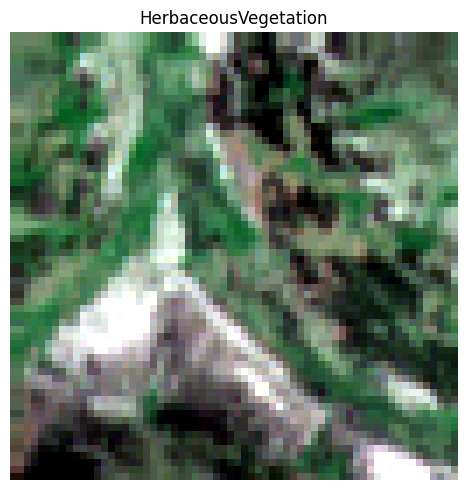

In [13]:
fig, ax = plt.subplots(1, figsize=(5,5))
ax.imshow(rgb_img)
ax.set_title(f"{label}")
ax.axis(False)
plt.tight_layout()

plt.show()

Note the `matplotlib` warning. Since we normalized the data by percentiles instead of maximum and minimum some (rare) pixels exceed the `[0.-1.]` range that `matplotlib` can handle. In such cases, the values are clipped to `1.`.

# Testset Data Loading

The testset has a slightly different structure than Eurosat. There are no labels and the data is stored in `numpy` `.npy` instead of GTiff.

First, we have to download the data from [Kaggle](https://www.kaggle.com/competitions/8-860-1-00-coding-challenge-2025/data).

In [16]:
#!pip install kaggle
!kaggle competitions download -c 8-860-1-00-coding-challenge-2025
#unzip
!unzip -q 8-860-1-00-coding-challenge-2025.zip


 95% 289M/303M [00:02<00:00, 112MB/s] 
100% 303M/303M [00:03<00:00, 105MB/s]


In [17]:

testset_dir = os.path.join("./testset/", "testset")
test_samples = glob.glob(os.path.join(testset_dir, "*.npy"))
len(test_samples)

4232

Now let's visualize a sample as we did for Eurosat

In [18]:
test_idx = 0

In [19]:
test_img = np.load(test_samples[test_idx])
test_img.shape

(64, 64, 12)

Then normalize the data and extract RGB channels

In [20]:
normalized_img = normalize_for_display(test_img)

In [21]:
rgb_img = normalized_img[:, :, [3,2,1]]

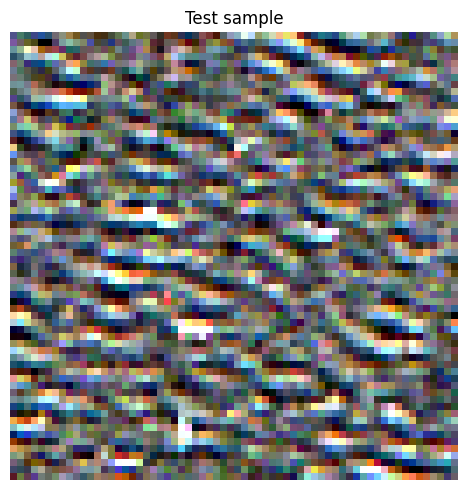

In [22]:
fig, ax = plt.subplots(1, figsize=(5,5))
ax.imshow(rgb_img)
ax.set_title(f"Test sample")
ax.axis(False)
plt.tight_layout()

plt.show()

### Bonus: Band arithmetic
The normalized difference vegetation index, or NDVI, is one of the most useful indices that can be derived from multi-spectral remote sensing data and indicates the presence of live green vegeation in an area.

> The pigment in plant leaves, chlorophyll, strongly absorbs visible light (from 400 to 700 nm) for use in photosynthesis. The cell structure of the leaves, on the other hand, strongly reflects near-infrared light (from 700 to 1100 nm).

From [Wikipedia](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index)

The NDVI exploits this difference in reflective properties of plants. It is computed as the ratio of the difference with the sum of near-infrared and red color bands. For the Sentinel2 data, this corresponds to the following:

`NDVI = (B8-B4)/(B8+B4)`

In [23]:
sample = samples[10]
label = sample.split('/')[-1].split('_')[0]

with rio.open(sample, "r") as d:
    img = d.read([1,2,3,4,5,6,7,8,9,10,11,12,13])

img = reshape_as_image(img)
normalized_img = normalize_for_display(img)
rgb_img = normalized_img[:, :, [3,2,1]]

Extract bands 4 and 8 from the data.

In [24]:
b8 = img[:, :, 7]
b4 = img[:, :, 3]

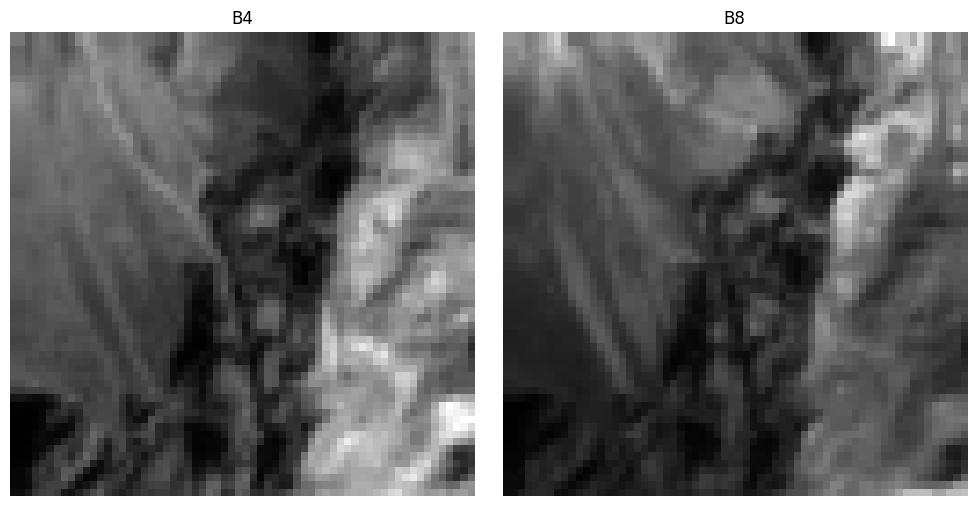

In [25]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].imshow(b4, cmap="gray")
axs[0].set_title("B4")
axs[0].axis(False)

axs[1].imshow(b8, cmap="gray")
axs[1].set_title("B8")
axs[1].axis(False)

plt.tight_layout()
plt.show()

Compute the NDVI:

In [26]:
ndvi = (b8-b4) / (b8+b4)

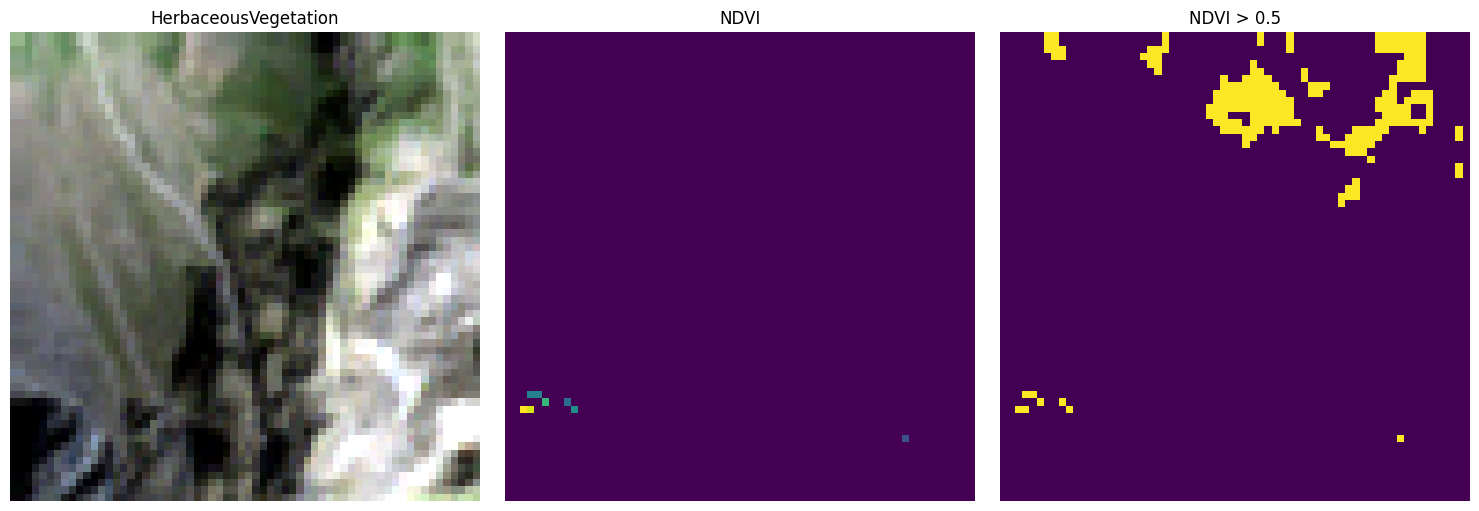

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

ax1.imshow(rgb_img)
ax1.set_title(f"{label}")
ax1.axis(False)

ax2.imshow(ndvi)
ax2.set_title(f"NDVI")
ax2.axis(False)

ax3.imshow(ndvi > .5)
ax3.set_title(f"NDVI > 0.5")
ax3.axis(False)

plt.tight_layout()
plt.show()

We can easily threshold NDVI values to obtain a segmentation mask of the vegetation in the image.

Let's also look at the bands individually.

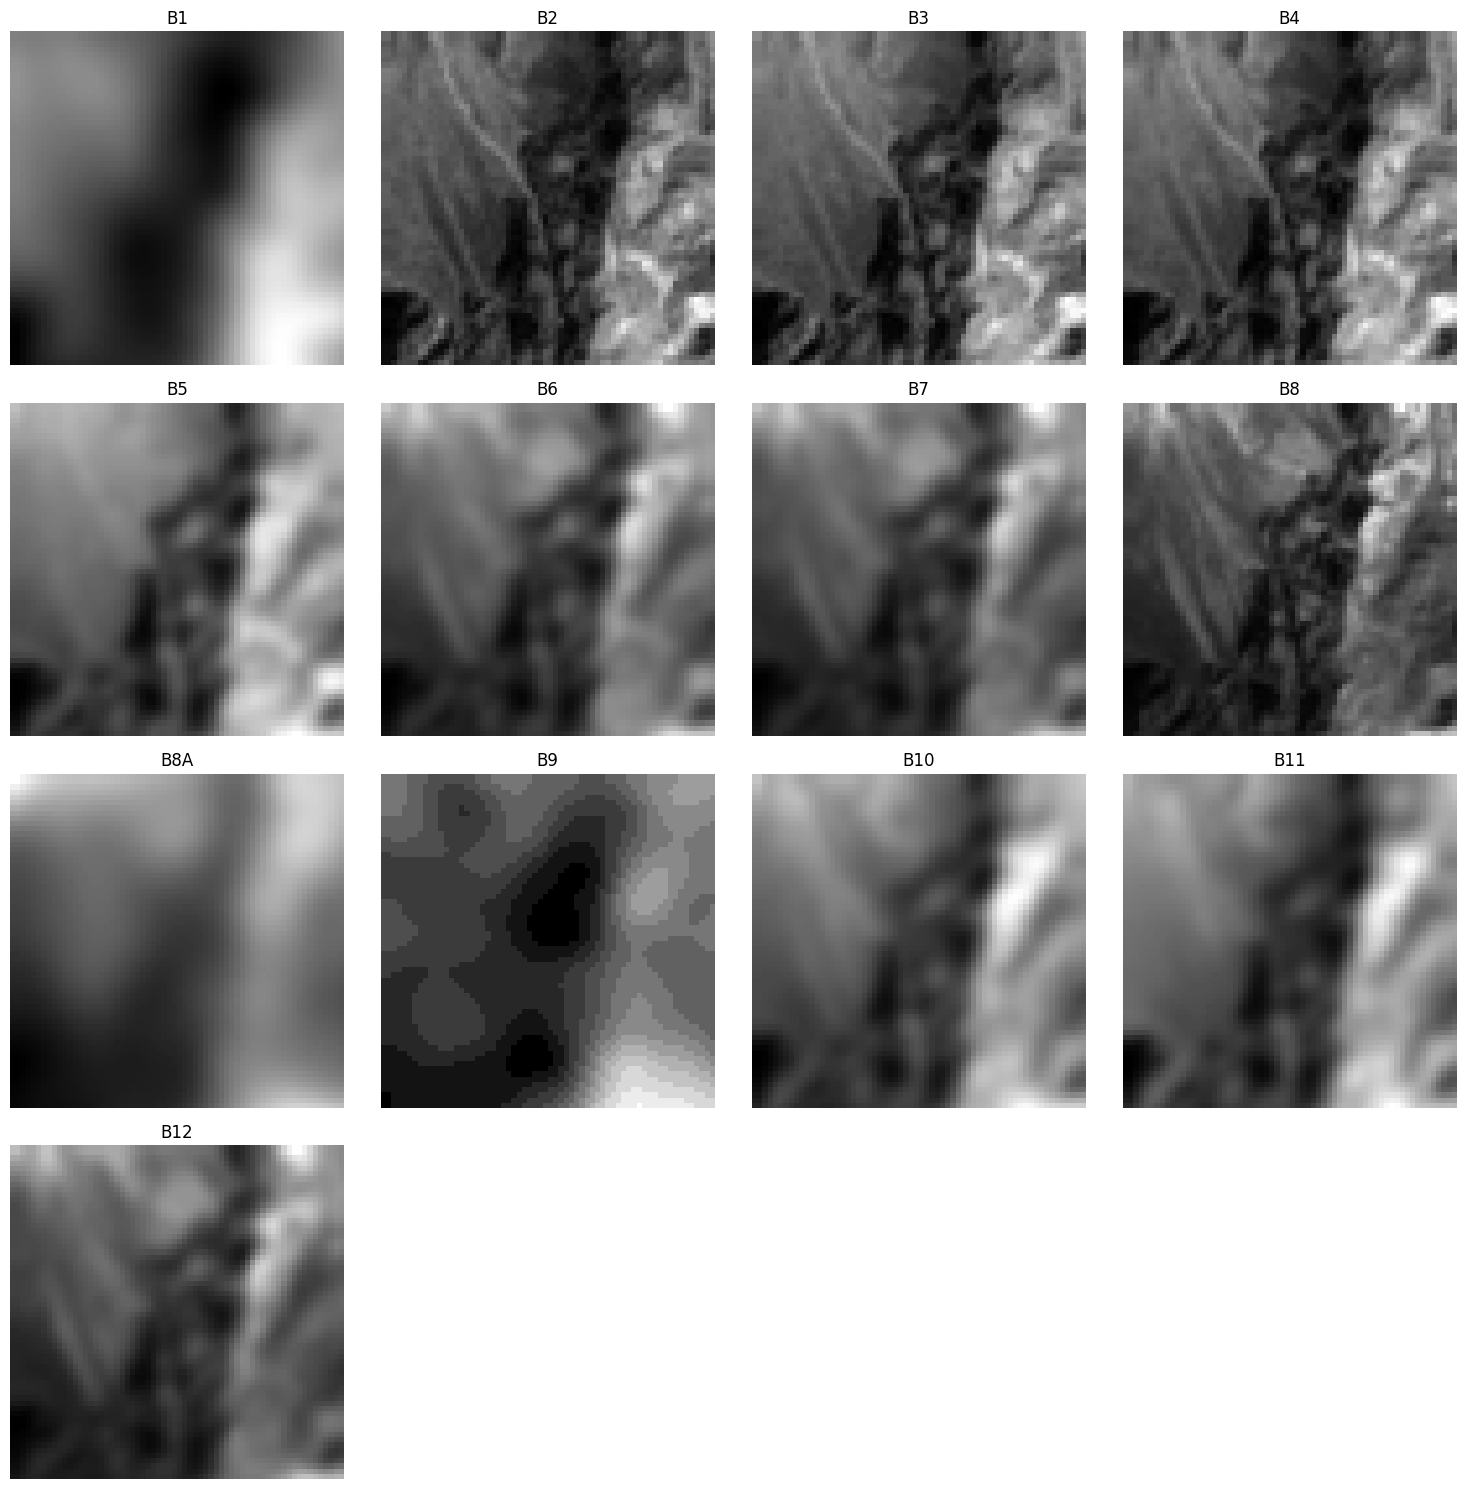

In [28]:
fig, axs = plt.subplots(4,4, figsize=(15,15))

band_idx = 0
bands = ["B1","B2","B3","B4","B5","B6","B7","B8","B8A","B9","B10","B11","B12"]

for i in range(4):
    for j in range(4):
        if band_idx < 13:
            axs[i,j].imshow(normalized_img[:, :, band_idx], cmap="gray")
            axs[i,j].set_title(bands[band_idx])
        else:
            axs[i,j].imshow(np.ones((64,64,3)), cmap="gray")

        axs[i,j].axis(False)
        band_idx += 1

plt.tight_layout()
plt.show()

## Next steps

Create a (deep learning) model to predict the most likely Eurosat class for each image of the testset. Think about creating the dataset class and data-loader for training, possible model architectures, and perhaps even how to best address the shift between train and test data.

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import os
import glob
from PIL import Image
import rasterio as rio
from rasterio.plot import reshape_as_image


# Define the dataset class
class EurosatDataset(Dataset):
    def __init__(self, data_dir, transform=None, train=True):
        self.data_dir = data_dir
        self.transform = transform
        self.train = train
        self.samples = []
        self.labels = []
        if self.train:
          for class_name in os.listdir(self.data_dir):
              class_dir = os.path.join(self.data_dir, class_name)
              if os.path.isdir(class_dir):
                  for filename in os.listdir(class_dir):
                      if filename.endswith(".tif"):
                          self.samples.append(os.path.join(class_dir, filename))
                          self.labels.append(classes.index(class_name))
        else:
            self.samples = glob.glob(os.path.join(self.data_dir, "*.npy"))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if self.train:
            with rio.open(self.samples[idx], "r") as d:
                img = d.read()
                img = reshape_as_image(img)
                img = normalize_for_display(img)
                img = img.astype(np.float32)
                # Stack the 13 bands along the channel dimension to create a 13-channel image
                img = np.transpose(img, (2, 0, 1)) # Change to CxHxW

                if self.transform:
                    img = self.transform(torch.from_numpy(img)) # Apply transform to the tensor

                return img, self.labels[idx]
        else:
            img = np.load(self.samples[idx])

            #The issue was here, the test data had shape (64, 64, 12)
            #instead of (64, 64, 13), so we need to add a dummy channel
            #to make it compatible with the model

            dummy_channel = np.zeros(img.shape[:2] + (1,)) #Create a dummy channel of zeros
            img = np.concatenate([img, dummy_channel], axis=2) #Concatenate the dummy channel to the image

            img = normalize_for_display(img)
            img = img.astype(np.float32)
            # Stack the 13 bands along the channel dimension to create a 13-channel image
            img = np.transpose(img, (2, 0, 1)) # Change to CxHxW
            if self.transform:
                img = self.transform(torch.from_numpy(img)) # Apply transform to the tensor
            return img


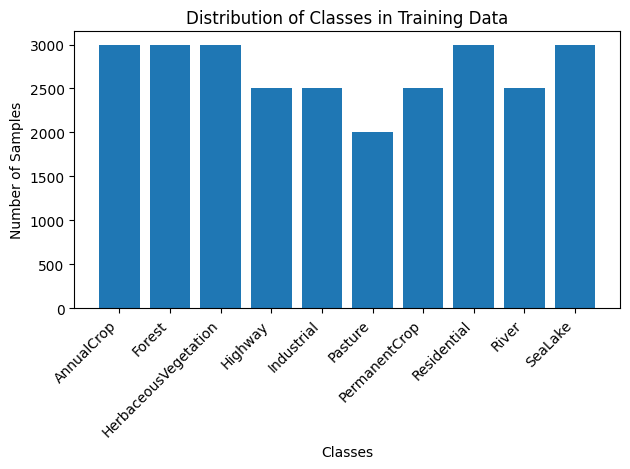

Epoch [1/10], Step [100/211], Loss: 1.5959
Epoch [1/10], Step [200/211], Loss: 1.6345
Epoch [2/10], Step [100/211], Loss: 1.4362
Epoch [2/10], Step [200/211], Loss: 1.2999
Epoch [3/10], Step [100/211], Loss: 1.2757
Epoch [3/10], Step [200/211], Loss: 1.3738
Epoch [4/10], Step [100/211], Loss: 1.3670
Epoch [4/10], Step [200/211], Loss: 1.3971
Epoch [5/10], Step [100/211], Loss: 1.4567
Epoch [5/10], Step [200/211], Loss: 1.1439
Epoch [6/10], Step [100/211], Loss: 1.2124
Epoch [6/10], Step [200/211], Loss: 1.1606
Epoch [7/10], Step [100/211], Loss: 1.0636
Epoch [7/10], Step [200/211], Loss: 1.1722
Epoch [8/10], Step [100/211], Loss: 1.1475
Epoch [8/10], Step [200/211], Loss: 1.1348
Epoch [9/10], Step [100/211], Loss: 1.2309
Epoch [9/10], Step [200/211], Loss: 1.1659
Epoch [10/10], Step [100/211], Loss: 1.0646
Epoch [10/10], Step [200/211], Loss: 1.0813


[9,
 9,
 0,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 7,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 7,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 7,
 9,
 9,
 9,
 9,
 9,
 9,
 7,
 9,
 9,
 9,
 9,
 9,
 7,
 9,
 9,
 9,
 9,
 9,
 9,
 6,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 7,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 7,
 9,
 9,
 9,
 4,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 7,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 7,
 9,
 9,
 9,
 7,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 7,
 9,
 9,
 9,
 9,
 7,
 7,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 0,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 4,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 7,
 9,
 7,
 9,
 9,
 9,
 9,
 7,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 7,
 9,
 9,


In [50]:
import torch.nn.init as init
# Define the model architecture
class EurosatModel(nn.Module):
       def __init__(self, num_classes=10):
           super(EurosatModel, self).__init__()
           self.features = nn.Sequential(
               nn.Conv2d(13, 64, kernel_size=3, padding=1),
               nn.ReLU(inplace=True),
               nn.Conv2d(64, 64, kernel_size=3, padding=1),
               nn.ReLU(inplace=True),
               nn.MaxPool2d(kernel_size=2, stride=2),
               nn.Conv2d(64, 128, kernel_size=3, padding=1),
               nn.ReLU(inplace=True),
               nn.Conv2d(128, 128, kernel_size=3, padding=1),
               nn.ReLU(inplace=True),
               nn.MaxPool2d(kernel_size=2, stride=2),
               nn.BatchNorm2d(128),  # After each convolutional layer
           )
           self.classifier = nn.Sequential(
               nn.Linear(128 * 16 * 16, 512),  # Adjust input size if needed
               nn.ReLU(inplace=True),
               nn.Dropout(),
               nn.Linear(512, num_classes),
               nn.Dropout(p=0.5),
           )
           # Apply weight initialization
           for m in self.modules():
               if isinstance(m, nn.Conv2d):
                   init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
               elif isinstance(m, nn.BatchNorm2d):
                   init.constant_(m.weight, 1)
                   init.constant_(m.bias, 0)

       def forward(self, x):
           x = self.features(x)
           x = x.view(x.size(0), -1)
           x = self.classifier(x)
           return x

#Checking for data imbalance using a histogram or bar plot
import matplotlib.pyplot as plt
# Get the counts for each class
class_counts = [train_dataset.labels.count(i) for i in range(len(classes))]

# Create a histogram
plt.bar(classes, class_counts)
plt.xlabel("Classes")
plt.ylabel("Number of Samples")
plt.title("Distribution of Classes in Training Data")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
# Data augmentation using transforms
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

train_dataset = EurosatDataset(data_dir="./ds/images/remote_sensing/otherDatasets/sentinel_2/tif", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = EurosatDataset(data_dir="./testset/testset", transform=transform, train=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EurosatModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR by 0.1 every 5 epochs


# Training loop
num_epochs = 10  # Adjust the number of epochs
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


# Inference on the test set
model.eval()
predictions = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

predictions

In [52]:
# prompt: generate csv for Kaggle and upload it

import pandas as pd
# Assuming 'predictions' is the list of predicted class labels from your model

text_predictions = [classes[pred] for pred in predictions]
# Create a DataFrame with the predictions
submission_df = pd.DataFrame({'test_id': range(len(text_predictions)), 'label': text_predictions})

# Save the DataFrame to a CSV file
submission_df.to_csv('_track1.csv', index=False)

# Upload the submission file to Kaggle
!kaggle competitions submit -c 8-860-1-00-coding-challenge-2025 -f _track1.csv -m "_track1"


100% 53.5k/53.5k [00:00<00:00, 84.6kB/s]
Successfully submitted to 8,860,1.00: Coding Challenge

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import os
import glob
from PIL import Image
import rasterio as rio
from rasterio.plot import reshape_as_image


# Load a pretrained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer to match the number of Eurosat classes
num_ftrs = model.fc.in_features
model.conv1 = nn.Conv2d(13, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(num_ftrs, 10)  # 10 classes in Eurosat

# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Data augmentation and loaders remain the same
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop
num_epochs = 5  # Adjust as needed
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


# Inference on the test set
model.eval()
predictions = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

predictions

Epoch [1/5], Step [100/211], Loss: 1.3163
Epoch [1/5], Step [200/211], Loss: 1.5989
Epoch [2/5], Step [100/211], Loss: 1.4053
Epoch [2/5], Step [200/211], Loss: 1.3590
Epoch [3/5], Step [100/211], Loss: 1.5169
Epoch [3/5], Step [200/211], Loss: 1.4729
Epoch [4/5], Step [100/211], Loss: 1.3475
Epoch [4/5], Step [200/211], Loss: 1.3596
Epoch [5/5], Step [100/211], Loss: 1.5548
Epoch [5/5], Step [200/211], Loss: 1.3357


[7,
 9,
 0,
 9,
 9,
 9,
 5,
 5,
 2,
 3,
 5,
 9,
 9,
 7,
 0,
 5,
 8,
 8,
 1,
 1,
 1,
 7,
 7,
 9,
 9,
 9,
 5,
 9,
 4,
 6,
 9,
 7,
 7,
 7,
 4,
 9,
 1,
 9,
 4,
 5,
 5,
 2,
 1,
 8,
 9,
 2,
 7,
 5,
 6,
 9,
 8,
 4,
 2,
 7,
 2,
 4,
 9,
 4,
 9,
 9,
 7,
 5,
 7,
 9,
 2,
 1,
 5,
 6,
 0,
 9,
 4,
 4,
 4,
 5,
 7,
 5,
 1,
 4,
 7,
 9,
 7,
 5,
 1,
 4,
 9,
 4,
 2,
 0,
 9,
 4,
 8,
 4,
 1,
 8,
 6,
 2,
 7,
 4,
 7,
 1,
 8,
 9,
 6,
 5,
 9,
 2,
 9,
 5,
 7,
 2,
 7,
 7,
 1,
 7,
 5,
 7,
 2,
 5,
 4,
 4,
 9,
 9,
 9,
 2,
 7,
 9,
 7,
 3,
 4,
 9,
 1,
 4,
 1,
 7,
 5,
 7,
 5,
 7,
 4,
 7,
 5,
 6,
 9,
 5,
 9,
 4,
 7,
 4,
 9,
 9,
 7,
 2,
 7,
 5,
 5,
 9,
 4,
 2,
 9,
 7,
 7,
 9,
 4,
 8,
 2,
 8,
 1,
 2,
 2,
 5,
 2,
 5,
 4,
 1,
 9,
 1,
 1,
 2,
 5,
 9,
 7,
 9,
 2,
 9,
 2,
 2,
 4,
 8,
 5,
 9,
 9,
 7,
 7,
 9,
 7,
 2,
 5,
 9,
 1,
 5,
 9,
 5,
 9,
 8,
 0,
 7,
 4,
 7,
 1,
 2,
 7,
 7,
 5,
 7,
 4,
 7,
 5,
 2,
 5,
 5,
 3,
 5,
 1,
 9,
 7,
 9,
 0,
 2,
 9,
 5,
 9,
 2,
 4,
 8,
 5,
 5,
 1,
 9,
 5,
 2,
 9,
 5,
 5,
 5,
 3,
 7,
 1,
 7,
 8,
 9,


In [57]:
# prompt: generate csv for Kaggle and upload it

import pandas as pd
# Assuming 'predictions' is the list of predicted class labels from your model

text_predictions = [classes[pred] for pred in predictions]
# Create a DataFrame with the predictions
submission_df = pd.DataFrame({'test_id': range(len(text_predictions)), 'label': text_predictions})

# Save the DataFrame to a CSV file
submission_df.to_csv('_track2.csv', index=False)

# Upload the submission file to Kaggle
!kaggle competitions submit -c 8-860-1-00-coding-challenge-2025 -f _track2.csv -m "_track2"


100% 62.0k/62.0k [00:00<00:00, 98.1kB/s]
Successfully submitted to 8,860,1.00: Coding Challenge